### LIBS & CONNECTOR

In [1]:
from IPython.display import clear_output
import math
import numpy as np
import pandas as pd
import sqlalchemy as sa
import mysql.connector
import getpass
import warnings
warnings.filterwarnings("ignore")

In [2]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN

In [3]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

ENGLISH_WORDS = set(words.words())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [37]:
from sklearn.linear_model import Ridge

In [4]:
HOST = 'localhost'
USER = 'root'
DATABASE = 'goodreads'
PASSWORD = getpass.getpass(f'Enter password for {USER}: ')

In [5]:
def getconn():
    conn = mysql.connector.connect(
        host=HOST,
        user=USER,
        password=PASSWORD,
        database=DATABASE
    )
    return conn

pool = sa.create_engine(
    "mysql+mysqlconnector://",
    creator=getconn,
)

with pool.connect() as db_conn:
    results = db_conn.execute(sa.text("SELECT NOW()")).fetchone()
    print("Current time: ", results[0])

Current time:  2023-06-13 19:55:12


### DATA

In [6]:
books_query = sa.text(
    "SELECT * FROM books;"
)
books_df = pd.read_sql_query(books_query, con=pool.connect())

In [12]:
indices = pd.Series(books_df.index, index=books_df.goodreads_book_id)

### MODEL

In [67]:
class Doc2VecModel:
    def __init__(self, data, data_id, data_document):
        self.data = data
        self.data_id = data_id
        self.data_document = data_document
        self.documents = data[data_document]
        self.ids = data[data_id]
        self.indices = pd.Series(data.index, index=self.ids)
        self.model = None
        self.docvecs = []
        self.sim_matrix = None

    def preprocess_doc(self):
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        docs_list = []
        for doc in self.documents:
            tokens = word_tokenize(doc)
            tokens = [token.lower() for token in tokens if token.lower(
            ) not in stop_words and token.isalpha() and token.lower() in ENGLISH_WORDS]
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
            docs_list.append(' '.join(tokens))
        return docs_list

    def get_feature_vectors(self, ids=[]):
        if ids:
            result_vectors = []
            for id in ids:
                result_vectors.append(self.docvecs[self.indices[id]])
            return (ids, result_vectors)
        else:
            return (self.indices.index, self.feature_vectors)

    def update_user(self, items, ratings, alpha=1):
        self.user_items = items
        _, self.items_vectors = self.get_feature_vectors(self.user_items)
        # ratings = np.array(ratings)
        self.user_ratings = ratings
        self.ridge = Ridge(alpha=alpha).fit(
            self.items_vectors, self.user_ratings)

    def get_personal_recommendations(self, top=5):
        a = []
        for id in self.ids.tolist():
            if id not in self.user_items:
                a.append(id)
        ids, remained = self.get_feature_vectors(a)
        predicts = self.ridge.predict(remained).flatten()
        pre_dict = dict(zip(ids, predicts))
        pre_dict = dict(
            sorted(pre_dict.items(), key=lambda item: item[1], reverse=True)[:top])
        return list(pre_dict.keys())

    def get_recommendations(self, book_id, num_recommends=5):
        idx = self.indices[book_id]
        sim_scores = list(enumerate(self.sim_matrix[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:num_recommends]
        item_indices = [i[0] for i in sim_scores]
        return self.data.iloc[item_indices]

    def score(self, measurement, test_data, test_ratings):
        _, test_vectors = self.get_feature_vectors(test_data)
        predicts = self.ridge.predict(test_vectors).flatten()
        score = measurement(predicts, test_ratings)
        return score

    def get_docvecs(self):
        return self.indices, self.docvecs

    def fit(self, vector_size=50):
        processed_docs = self.preprocess_doc()
        documents = [TaggedDocument(doc, [index])
                     for index, doc in enumerate(processed_docs)]
        self.model = Doc2Vec(documents, vector_size=vector_size,
                             window=5, min_count=3, workers=4, epochs=5)
        data_len = len(self.ids)
        self.docvecs = []
        for i in range(0, data_len):
            self.docvecs.append(self.model.docvecs[i])
        self.sim_matrix = cosine_similarity(self.docvecs)


In [68]:
book_id = 'goodreads_book_id'
description = 'description'
model = Doc2VecModel(books_df, book_id, description)
model.fit(vector_size=100)

In [69]:
ratings = pd.read_csv('./data/main/ratings_train.dat', sep=':', header=None)
ratings_test = pd.read_csv('./data/main/ratings_test.dat', sep=':', header=None)

In [92]:
user_1 = ratings.loc[ratings[0] == 1]
user_1_test = ratings_test.loc[ratings[0] == 1]

In [93]:
uitems = user_1[1].astype(str).tolist()
uratings = user_1[2].tolist()
uitems_test = user_1_test[1].astype(str).tolist()
uratings_test = user_1_test[2].tolist()

In [94]:
model.update_user(uitems, uratings)

In [95]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import MinMaxScaler as MMS

In [96]:
mse = []
for size in range(100, 1000, 100):
    clear_output(wait=True)
    print(f'fitting with size of {size}.')
    model.fit(vector_size=500)
    model.update_user(uitems, uratings)
    mse.append(model.score(MSE, uitems_test, uratings_test))

fitting with size of 900.


In [97]:
import matplotlib.pyplot as plt

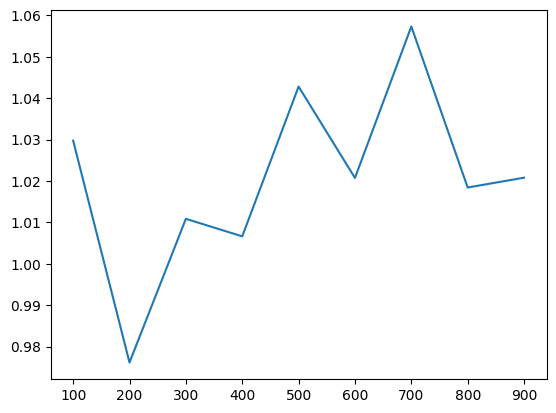

In [98]:
plt.plot(range(100, 1000, 100), mse)

In [110]:
scaler = MMS()

In [118]:
allratings = np.array(uratings + uratings_test)
uratings = np.array(uratings)
uratings_test = np.array(uratings_test)

In [119]:
uratings_scaled = scaler.fit(allratings.reshape(-1,1))
uratings = scaler.transform(uratings.reshape(-1,1))
uratings_test = scaler.transform(uratings_test.reshape(-1,1))

In [124]:
model.update_user(uitems, uratings)
model.score(MSE, uitems_test, uratings_test)

0.06380018800290718

In [131]:
mse = []
for size in range(50, 1001, 50):
    clear_output(wait=True)
    print(f'fitting with size of {size}.')
    model.fit(vector_size=size)
    print('updating profile.')
    model.update_user(uitems, uratings)
    mse.append(model.score(MSE, uitems_test, uratings_test))

fitting with size of 1000.
updating profile.


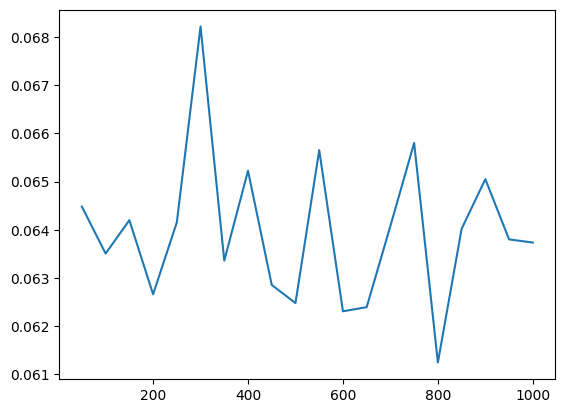

In [132]:
plt.plot(range(50, 1001, 50), mse)